# Analyse Exploratoire

Ce notebook renferme toute l'analyse exploratoire concernant le projet "Segmentez des clients d'un site e-commerce".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import warnings
warnings.filterwarnings('ignore')

### Méthodes du projet

In [2]:
def translate_product_category(data_products):
    mapping_names = pd.read_csv("product_category_name_translation.csv", encoding='utf-8', sep=',', index_col="product_category_name").to_dict()
    if 'product_category_name' in data_products.columns:
        data_products.replace({"product_category_name": mapping_names['product_category_name_english']}, inplace=True)

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [4]:
def show_unique_values(df, col, display_pie=True):
    temp_val_count = df[col].value_counts(normalize=True)
    display(temp_val_count.head())
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()

In [5]:
def show_missing_value_list(df, top=10, precision=3):
    miss_values = round(df.isnull().mean()*100, precision).sort_values(ascending=False)
    missing_val_df = pd.DataFrame(miss_values, columns = ["%"])
    display(missing_val_df.head(top))

In [6]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [7]:
def show_corr_col(df, data_num, threshold=0.9, top=10):
    list_col_num = data_num.columns
    corr = df[list_col_num].corr().values
    nb_col = len(data_num.columns)
    res = []
    for i in range(nb_col):
        for j in range(i+1, nb_col):
            if abs(corr[i,j]) >= threshold:
                # print(list_col_num[i], ' ', list_col_num[j], ' ', round(corr[i,j], 3))
                res.append([list_col_num[i], list_col_num[j], round(corr[i,j], 3)])
    result = pd.DataFrame(res, columns=['col1', 'col2', 'corr'])
    result = result.sort_values(by="corr", ascending=False)
    display(result.head(top))

In [8]:
def plot_univarie(df, list_col):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=25)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [9]:
def boxplot_univarie(df, list_col, showfliers=True):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        display(df.head())
        df.boxplot(column=col, vert=False, showfliers=showfliers)
        plt.show()
        print("-"*70)

In [10]:
def show_pair_plot(df):
    temp_data_num, *remain = split_data_num_categ(df, silent=True)
    sns.pairplot(df[temp_data_num.columns])

In [11]:
def remove_dupli_row(df, col_to_compare):
    nb_line_orig = df.shape[0]
    df = df[col_to_compare].drop_duplicates().reset_index(drop=True)
    diff = nb_line_orig - df.shape[0]
    if diff > 0:
        print("En supprimant les", diff, "lignes dupliquées, le dataset passe de", nb_line_orig, "lignes à", df.shape[0], "lignes.")
    else:
        print("Aucunes lignes dupliquées pour la liste de colonnes :", col_to_compare)

In [12]:
def display_pie_plot(df, list_col):
    for col in list_col:
        print("Colonne :", col)
        temp_val_count = df[col].value_counts(normalize=True)
        temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.show()

In [13]:
def show_corr_anova_col(df, list_col_categ, list_col_num, threshold=0.6):
    # X : variable qualitative, ie catégorielle
    # Y : variable quantitative, ie numérique
    def eta_squared(x,y):
        moyenne_y = y.mean()
        classes = []
        for classe in x.unique():
            yi_classe = y[x==classe]
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
        SCT = sum([(yj-moyenne_y)**2 for yj in y])
        SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
        return SCE/SCT
    
    start = time.time()
    print("On dénombre", len(list_col_categ) * len(list_col_num), "combinaisons à calculer.")
    for X in list_col_categ:
        # print("Colonne catégorielle :", X)
        for Y in list_col_num:
            # print("Colonne numérique :", Y)
            temp_eta = eta_squared(df[X],df[Y])
            if temp_eta >= threshold:
                print("Correlation de", round(temp_eta, 3))
    
    end = time.time()
    delta = round(end - start, 0)
    print("Corrélations ANOVA calculées en :", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

# I) Elaboration du dataset brut

Les données sont dispersées en 8 fichiers. Nous allons d'abord charger chaque fichier pour effectuer un traitement de filtrage préalable si besoin.

## Chargement et traitement des différents fichiers

Il est plus pertinent de faire les traitements de nettoyage et filtrage avant de fusionner les tables. En effet, la fusion va provoquer la création de lignes supplémentaires avec des valeurs manquantes en plus. Cela va complètement déséquilibrer le master dataset et donc biaiser le traitement des valeurs manquantes.

### Customers

In [14]:
data_customers = pd.read_csv(
    "input/olist_customers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object) # le zip code peut commencer par 0

In [15]:
data_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Regardons les variables de ce dataset : 
 - `customer_id` : identifiant servant de foreign key pour la table **orders**
 - `customer_unique_id` : identifiant unique du client. Un même identifiant unique peut avoir plusieurs `customer_id`
 - `customer_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `customer_city` : ville où vit le client
 - `customer_state` : état où vit le client

In [16]:
print("Ce dataset présente", data_customers.shape[0], "lignes pour", data_customers.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 5 colonnes.


### Products

In [17]:
data_products = pd.read_csv(
    "input/olist_products_dataset.csv", encoding='utf-8', sep=',')

In [18]:
data_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Regardons les variables de ce dataset : 
 - `product_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `product_category_name` : catégorie du produit
 - `product_name_lenght` : longueur du nom sur la fiche produit
 - `product_description_lenght` : longueur de la description sur la fiche produit
 - `product_photos_qty` : nombre de photo sur la fiche produit
 - `product_weight_g` : poids du produit
 - `product_length_cm` : longueur du produit
 - `product_height_cm` : hauteur du produit
 - `product_width_cm` : largeur du produit

La variable `product_category_name` peut être traduite par l'intérmédiaire du fichier fournit en annexe.

In [19]:
translate_product_category(data_products)

Regardons les corrélations possibles entre les différentes variables numériques.

In [20]:
# show_pair_plot(data_products)

On n'observe rien de marquant. Regardons maintenant les valeurs manquantes.

In [21]:
show_missing_value_list(data_products)

,%
product_category_name,1.851
product_name_lenght,1.851
product_description_lenght,1.851
product_photos_qty,1.851
product_weight_g,0.006
product_length_cm,0.006
product_height_cm,0.006
product_width_cm,0.006
product_id,0.000


On remarque que certaines variables ont la même valeur de données manquantes : 
 - la désignation de la fiche produit
 - les dimensions

Même si certaines données sont manquantes, ils peuvent avoir été achetés. ils ont donc potentiellement un prix et une fréquence d'achat. Nous allons donc les garder mais les traiter de la manière suivante : 
 - `product_category_name` : on renseigne la valeur "not_defined" car aucun moyen de savoir ce qu'est le produit
 - `product_name_lenght`, `product_description_lenght` et `product_photos_qty` : on renseigne la valeur minimale car nous faisons l'approximation qu'on ne peut créer une fiche sans aucune de ces données
 - `product_weight_g`, `product_length_cm`, `product_height_cm` et `product_width_cm` : on renseigne la valeur médiane

In [22]:
# traitement avec Other
data_products["product_category_name"].fillna("not_defined", inplace=True)
# traitement par le minimum
for col_fiche in ["product_name_lenght", "product_description_lenght", "product_photos_qty"]:
    data_products[col_fiche].fillna(data_products[col_fiche].min(), inplace=True)
# traitement par la médiane
for col_dim in ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]:
    data_products[col_dim].fillna(data_products[col_dim].median(), inplace=True)

Regardons maintenant les outliers.

In [23]:
data_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000
mean,47.672089,757.287154,2.166975,2276.376802,30.814725,16.937422,23.196534
std,11.720832,637.657356,1.728063,4281.926387,16.914005,13.637175,12.078707
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,41.000000,326.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,584.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,961.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


La seule valeur aberrante observée est le poids minimum à 0g.

In [24]:
poids_a_zero = data_products.loc[data_products["product_weight_g"]==0]
print("Poids à zéro :", len(poids_a_zero), ", soit", str(round(len(poids_a_zero)/len(data_products)*100, 2)), "% du total.")

Poids à zéro : 4 , soit 0.01 % du total.


In [25]:
poids_a_zero.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,bed_bath_table,51.0,529.0,1.0,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,bed_bath_table,48.0,528.0,1.0,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,bed_bath_table,53.0,528.0,1.0,0.0,30.0,25.0,30.0
32079,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,53.0,528.0,1.0,0.0,30.0,25.0,30.0


On voit que ces produits sont de la même catégorie et ont les mêmes dimensions. On va donc récupérer la valeur médiane des produits ayant ces critères.

In [26]:
filtered_poids_zero = data_products.loc[
    (data_products["product_category_name"]=="bed_bath_table") &
    (data_products["product_length_cm"]==30) &
    (data_products["product_height_cm"]==25) &
    (data_products["product_width_cm"]==30) &
    (data_products["product_weight_g"]!=0), :]
data_products.loc[data_products["product_weight_g"]==0,"product_weight_g"] = filtered_poids_zero["product_weight_g"].median()

In [27]:
# data_products["product_volume_l"] = data_products["product_length_cm"] * data_products["product_height_cm"] * data_products["product_width_cm"] / 1000

In [28]:
print("Ce dataset présente", data_products.shape[0], "lignes pour", data_products.shape[1], "colonnes.")

Ce dataset présente 32951 lignes pour 9 colonnes.


### Sellers

In [29]:
data_sellers = pd.read_csv(
    "input/olist_sellers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object) # le zip code peut commencer par 0

In [30]:
data_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Regardons les variables de ce dataset : 
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `seller_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `seller_city` : ville où est basé le vendeur
 - `seller_state` : état dans lequel est basé le vendeur

In [31]:
print("Ce dataset présente", data_sellers.shape[0], "lignes pour", data_sellers.shape[1], "colonnes.")

Ce dataset présente 3095 lignes pour 4 colonnes.


### Geolocation

In [32]:
data_geolocation = pd.read_csv(
    "input/olist_geolocation_dataset.csv", encoding='utf-8', sep=',',
    dtype={'geolocation_zip_code_prefix': 'object'}) # le zip code peut commencer par 0

In [33]:
data_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


Regardons les variables de ce dataset : 
 - `geolocation_zip_code_prefix` : identifiant servant de foreign key pour les tables **customers** et **sellers**
 - `geolocation_lat` : latitude
 - `geolocation_lng` : longitude
 - `geolocation_city` : ville
 - `geolocation_state` : état (du pays)

In [34]:
remove_dupli_row(data_geolocation, data_geolocation.columns)

En supprimant les 261831 lignes dupliquées, le dataset passe de 1000163 lignes à 738332 lignes.


In [35]:
print("Ce dataset présente", data_geolocation.shape[0], "lignes pour", data_geolocation.shape[1], "colonnes.")

Ce dataset présente 1000163 lignes pour 5 colonnes.


### Payments

In [36]:
data_payments = pd.read_csv(
    "input/olist_order_payments_dataset.csv", encoding='utf-8', sep=',')

In [37]:
data_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `payment_sequential` : séquence d'un paiement si en plusieurs fois
 - `payment_type` : méthode de paiement
 - `payment_installments` : nombre d'échance pour le paiement de la commande
 - `payment_value` : montant de la transaction

NB : Je voulais faire une aggrégation des données pour avoir le montant total et le nombre d'échéance payées. Mais le fait que la commande peut avoir plusieurs méthodes de paiement m'en empêche.

In [38]:
data_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


On voit des valeurs aberrantes pour le montant de la transaction et le nombre d'échéance avec des valeurs à zéro.

In [39]:
mont_trans_a_zero = data_payments.loc[data_payments["payment_value"]==0, :]
print("Montant de la transaction à zéro :", len(mont_trans_a_zero), ", soit", str(round(len(mont_trans_a_zero)/len(data_payments)*100, 2)), "% du total.")
mont_trans_a_zero.head(len(mont_trans_a_zero))

Montant de la transaction à zéro : 9 , soit 0.01 % du total.


,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


Le type de paiement de ces montants sont voucher (bon alimentaire) et non défini. Regardons les séparément.

In [40]:
pay_voucher = data_payments.loc[data_payments["payment_type"]=="voucher", :]
pay_voucher.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
68,947e9c6bfd83a06953c420ef92d3da6e,1,voucher,1,69.46
70,e3e9e3295f4e1512167c232a0aaae8a5,1,voucher,1,50.80
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12


Les bons alimentaires ont des montants. nous allons renseigner la valeur médiane pour celle à 0.

In [41]:
filtered_voucher_zero = data_payments.loc[
    (data_payments["payment_type"]=="voucher") &
    (data_payments["payment_value"]!=0), :]
data_payments.loc[
    (data_payments["payment_type"]=="voucher") &
    (data_payments["payment_value"]==0),
    "payment_value"] = filtered_voucher_zero["payment_value"].median()

In [42]:
pay_not_defined = data_payments.loc[data_payments["payment_type"]=="not_defined", :]
pay_not_defined.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


Les 3 seules lignes de paiement ayant le type non défini ont des montants à zéro. Nous allons supprimer ces lignes.

In [43]:
data_payments = data_payments.loc[data_payments["payment_type"] != "not_defined", :].reset_index(drop=True)

In [44]:
pay_install_a_zero = data_payments.loc[data_payments["payment_installments"]==0, :]
pay_install_a_zero.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79012,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


Regardons les autres lignes de cette commande.

In [45]:
temp_sub_pay = data_payments.loc[
    (data_payments["order_id"]=='744bade1fcf9ff3f31d860ace076d422') | 
    (data_payments["order_id"]=='1a57108394169c0b47d8f876acc9ba2d'), :]
temp_sub_pay.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79012,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


Etant donné la nature de la colonne, la valeur est de minimum 2 puisqu'il y a cette valeur dans le nombre de séquence. Nous choisissons de renseigner 2.

In [46]:
data_payments.loc[
    (data_payments["order_id"]=='744bade1fcf9ff3f31d860ace076d422') | 
    (data_payments["order_id"]=='1a57108394169c0b47d8f876acc9ba2d'),
    "payment_installments"] = 2

Nous allons observer où en sont les paiements dans leurs échéances.

In [47]:
agg_pay = {
    'payment_sequential': ['min', 'max', 'count'],
    'payment_installments': ['min', 'max', 'count'],
}

In [48]:
compare_seq = data_payments.groupby(['order_id']).agg(agg_pay)
compare_seq.head()

payment_sequential            \
                                                min max count   
order_id                                                        
00010242fe8c5a6d1ba2dd792cb16214                  1   1     1   
00018f77f2f0320c557190d7a144bdd3                  1   1     1   
000229ec398224ef6ca0657da4fc703e                  1   1     1   
00024acbcdf0a6daa1e931b038114c75                  1   1     1   
00042b26cf59d7ce69dfabb4e55b4fd9                  1   1     1   

                                 payment_installments            
                                                  min max count  
order_id                                                         
00010242fe8c5a6d1ba2dd792cb16214                    2   2     1  
00018f77f2f0320c557190d7a144bdd3                    3   3     1  
000229ec398224ef6ca0657da4fc703e                    5   5     1  
00024acbcdf0a6daa1e931b038114c75                    2   2     1  
00042b26cf59d7ce69dfabb4e55b4fd9                    3   3     1

On voit tout de suite que l'on a des commandes qui en sont à leur premier versement alors qu'il est prévu plus. Ce qui implique que nous n'avons pas toutes les données disponible pour cette table. Il est possible qu'elle ne nous soit pas très utile pour notre étude. Nous allons néanmoins quantifier à quel point cette table manque de données.

In [49]:
def evaluate_miss_pay_data(df):
    compare_seq["delta_seq"] = compare_seq[('payment_sequential', 'max')] - compare_seq[('payment_sequential', 'min')] + 1
    compare_seq["delta_install"] = compare_seq[('payment_installments', 'max')] - compare_seq[('payment_installments', 'min')] + 1
    compare_seq["delta_counts"] = compare_seq[('payment_installments', 'count')] - compare_seq[('payment_sequential', 'count')]
    
    compare_seq["miss_count"] = 0
    compare_seq.loc[compare_seq[("delta_seq", "")] != compare_seq[('payment_sequential', 'count')], "miss_count"] += 1
    compare_seq.loc[compare_seq[("delta_install", "")] != compare_seq[('payment_installments', 'count')], "miss_count"] += 1
    compare_seq.loc[compare_seq[("delta_counts", "")] != 0, "miss_count"] += 1
    
evaluate_miss_pay_data(compare_seq)

In [50]:
nb_orders = data_payments["order_id"].nunique()
nb_miss_pay = len(compare_seq.loc[compare_seq["miss_count"] > 0, :])
print("Il manque des données pour", nb_miss_pay, "commandes, soit", str(round(nb_miss_pay/nb_orders*100, 2)), "% des commandes.")

Il manque des données pour 2691 commandes, soit 2.71 % des commandes.


In [51]:
print("Ce dataset présente", data_payments.shape[0], "lignes pour", data_payments.shape[1], "colonnes.")

Ce dataset présente 103883 lignes pour 5 colonnes.


### Reviews

In [52]:
review_date_col = [
    "review_creation_date",
    "review_answer_timestamp"]
data_reviews = pd.read_csv(
    "input/olist_order_reviews_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=review_date_col)

In [53]:
data_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


Regardons les variables de ce dataset : 
 - `review_id` : identifiant unique de la review
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `review_score` : note de la review allant de 1 à 5
 - `review_comment_title` : titre du commentaire de la review
 - `review_comment_message` : corps du commentaire de la review
 - `review_creation_date` : date à laquelle la review a été publiée
 - `review_answer_timestamp` : date à laquelle la review a eu une réponse

In [54]:
show_missing_value_list(data_reviews, top=5, precision=1)

,%
review_comment_title,88.3
review_comment_message,58.7
review_id,0.0
order_id,0.0
review_score,0.0


On peut voir que les notes sont certes toutes renseignée, mais les commentaires ne sont pas forcément remplis. Etant donné le peu de données dans les colonnes `review_comment_title` et `review_comment_message`, nous choisissons de les supprimer.

In [55]:
data_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

In [56]:
print("Ce dataset présente", data_reviews.shape[0], "lignes pour", data_reviews.shape[1], "colonnes.")

Ce dataset présente 99224 lignes pour 5 colonnes.


### Items

In [57]:
data_items = pd.read_csv(
    "input/olist_order_items_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=["shipping_limit_date"])

In [58]:
data_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Regardons les variables de ce dataset : 
 - `order_id` : identifiant unique de la commande
 - `order_item_id` : quantité d'achat du produit
 - `product_id` : identifiant servant de aussi de foreign key pour la table **products**
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **sellers**
 - `shipping_limit_date` : date limite pour le vendeur pour confier le produit au service logistique
 - `price` : prix du produit au moment de la commande
 - `freight_value` : frais de port associés au produit (et non à la commande entière) au moment de la commande

Dans order_items, les produits sont présents plusieurs fois. Pour chaque produits, on a une ligne par quantité d'achat. Chaque ligne nous montre son prix et ses frais de port au moment de l'achat. La variable `order_item_id` renseigne sur la quantité achetée. S'il y a 3 items dans le même panier, il y aura 3 lignes avec les valeurs 1, 2 et 3. Il y aura cependant la même valeurs pour le prix et les frais de port.    
On va d'abord ordonner les lignes par ordre décroissant de la variable `order_item_id`. Puis on va garder la première des lignes dupliquées selon les critères des autres colonnes.

In [59]:
nb_lines_orig_oi = data_items.shape[0]
data_items = data_items.sort_values('order_item_id', ascending=False).drop_duplicates(["order_id", "product_id", "seller_id", "price", "freight_value"])
diff = nb_lines_orig_oi - data_items.shape[0]
print("En supprimant les", diff, "lignes dupliquées, le dataset passe de", nb_lines_orig_oi, "lignes à", data_items.shape[0], "lignes.")

En supprimant les 10225 lignes dupliquées, le dataset passe de 112650 lignes à 102425 lignes.


In [60]:
data_items.describe()

,order_item_id,price,freight_value
count,102425.000000,102425.000000,102425.000000
mean,1.150539,124.422006,20.111152
std,0.563005,188.926084,15.884700
min,1.000000,0.850000,0.000000
25%,1.000000,40.000000,13.140000
50%,1.000000,78.800000,16.320000
75%,1.000000,139.000000,21.220000
max,21.000000,6735.000000,409.680000


Nous voyons de possibles outliers au niveau du prix et des frais de port. On a des valeurs maximales à, respectivement, 6735 et 409,68. Cependant, nous ne savons pas quel genre de produit nous avons. Il est possible que ce soit les vrai prix, surtout s'ils sont exprimés en real brésilien. Pour les frais de port, en fonction du colis, on peut très bien arriver à ce genre de valeur.

In [61]:
print("Ce dataset présente", data_items.shape[0], "lignes pour", data_items.shape[1], "colonnes.")

Ce dataset présente 102425 lignes pour 7 colonnes.


### Orders

In [62]:
order_date_col = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
data_orders = pd.read_csv(
    "input/olist_orders_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=order_date_col)

In [63]:
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `customer_id` : identifiant servant de aussi de foreign key pour la table **customers**
 - `order_status` : étape dans laquelle est la commande
 - `order_purchase_timestamp` : date à laquelle la commande a été faite par le client
 - `order_approved_at` : date à laquelle le paiement a été approuvé
 - `order_delivered_carrier_date` : date à laquelle le colis a été confié au service de logistique
 - `order_delivered_customer_date` : date à laquelle le colis a été livré au client
 - `order_estimated_delivery_date` : date estimée de livraison au moment de la commande

In [64]:
remove_dupli_row(data_orders, data_orders.columns)

Aucunes lignes dupliquées pour la liste de colonnes : Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [65]:
show_missing_value_list(data_orders)

,%
order_delivered_customer_date,2.982
order_delivered_carrier_date,1.793
order_approved_at,0.161
order_id,0.000
customer_id,0.000
order_status,0.000
order_purchase_timestamp,0.000
order_estimated_delivery_date,0.000


Regardons de plus près les 3 dates ayant des valeurs manquantes. Elles peuvent être justifiées.

In [66]:
sub_data_delivered_date = data_orders.loc[data_orders["order_delivered_customer_date"].isnull(), :]
show_unique_values(sub_data_delivered_date, 'order_status', display_pie=False)

shipped        0.373356
canceled       0.208769
unavailable    0.205396
invoiced       0.105902
processing     0.101518
Name: order_status, dtype: float64

La date de livraisons n'est pas renseignée pour des colis non livrés. Donc c'est normal.

In [67]:
sub_data_carrier_date = data_orders.loc[data_orders["order_delivered_carrier_date"].isnull(), :]
show_unique_values(sub_data_carrier_date, 'order_status', display_pie=False)

unavailable    0.341559
canceled       0.308469
invoiced       0.176108
processing     0.168817
created        0.002804
Name: order_status, dtype: float64

La date indiquant que le colis a été confié à la logistique n'est pas renseignée pour des colis non envoyés. Donc c'est normal.

In [68]:
sub_data_approuved_date = data_orders.loc[data_orders["order_approved_at"].isnull(), :]
show_unique_values(sub_data_approuved_date, 'order_status', display_pie=False)

canceled     0.88125
delivered    0.08750
created      0.03125
Name: order_status, dtype: float64

La date d'approbation de la commande n'est pas renseigné pour des colis livrés. Ce n'est pas normal. Regardons ça de plus près.

In [69]:
sub_deliv_appr_date = data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"), :]
sub_deliv_appr_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20


Pour plus de cohérence, nous allons renseigner la date de commande + 1 seconde.

In [70]:
data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"),
    "order_approved_at"] = data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"),
    "order_purchase_timestamp"] + pd.to_timedelta(1, unit='s')

In [71]:
print("Ce dataset présente", data_orders.shape[0], "lignes pour", data_orders.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 8 colonnes.


## Elaboration dataset brut

In [72]:
data = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data = pd.merge(data, data_payments, on="order_id", how="inner")
data = pd.merge(data, data_reviews, on="order_id", how="inner")
data = pd.merge(data, data_items, on="order_id", how="inner")
data = pd.merge(data, data_products, on="product_id", how="inner")
data = pd.merge(data, data_sellers, on="seller_id", how="inner")
print("There are", data.shape[0], "lines characterised by", data.shape[1], "columns.")

There are 106837 lines characterised by 37 columns.


In [73]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,88460,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP


In [74]:
data_num, data_categ, data_date = split_data_num_categ(data)

Voici la répartition des colonnes par type de données :
numeric : 14 colonnes.
category : 15 colonnes.
boolean : 0 colonnes.
datetime : 8 colonnes.
deltatime : 0 colonnes.


In [75]:
data.to_csv("master_dataset.csv", sep='\t', encoding='utf-8')

# II) Elaboration des dataset d'étude

## Dataset sur les Clients

In [76]:
data_customers_study = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data_customers_study = pd.merge(data_customers_study, data_items, on="order_id", how="inner")
print("There are", data_customers_study.shape[0], "lines characterised by", data_customers_study.shape[1], "columns.")

There are 102425 lines characterised by 18 columns.


In [77]:
data_customers_study.to_csv("customers_dataset.csv", sep='\t', encoding='utf-8')

## Dataset sur les Clients + Reviews

In [78]:
data_cust_rev_study = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data_cust_rev_study = pd.merge(data_cust_rev_study, data_reviews, on="order_id", how="inner")
data_cust_rev_study = pd.merge(data_cust_rev_study, data_items, on="order_id", how="inner")
print("There are", data_cust_rev_study.shape[0], "lines characterised by", data_cust_rev_study.shape[1], "columns.")

There are 102230 lines characterised by 22 columns.


In [79]:
data_cust_rev_study.to_csv("customers_rev_dataset.csv", sep='\t', encoding='utf-8')

## Dataset sur les Clients + Reviews + Produits

In [80]:
data_cust_rev_prod_study = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data_cust_rev_prod_study = pd.merge(data_cust_rev_prod_study, data_reviews, on="order_id", how="inner")
data_cust_rev_prod_study = pd.merge(data_cust_rev_prod_study, data_items, on="order_id", how="inner")
data_cust_rev_prod_study = pd.merge(data_cust_rev_prod_study, data_products, on="product_id", how="inner")
print("There are", data_cust_rev_prod_study.shape[0], "lines characterised by", data_cust_rev_prod_study.shape[1], "columns.")

There are 102230 lines characterised by 30 columns.


In [81]:
data_cust_rev_prod_study.to_csv("customers_rev_prod_dataset.csv", sep='\t', encoding='utf-8')

## Dataset sur les Produits

In [82]:
data_prod_study = pd.merge(data_products, data_items, on="product_id", how="inner")
print("There are", data_prod_study.shape[0], "lines characterised by", data_prod_study.shape[1], "columns.")

There are 102425 lines characterised by 15 columns.


In [83]:
data_prod_study.to_csv("products_dataset.csv", sep='\t', encoding='utf-8')

# II) Analyse

Vérifions les données manquantes sur l'ensemble du jeu de données.

In [84]:
show_missing_value_list(data, top=5)

,%
order_delivered_customer_date,2.113
order_delivered_carrier_date,1.001
seller_id,0.000
shipping_limit_date,0.000
price,0.000


Nous avons bien uniquement les colonnes `order_delivered_customer_date` et `order_delivered_carrier_date`  ayant des valeurs manquantes justifiées.

### Colonnes Date

Colonne order_purchase_timestamp


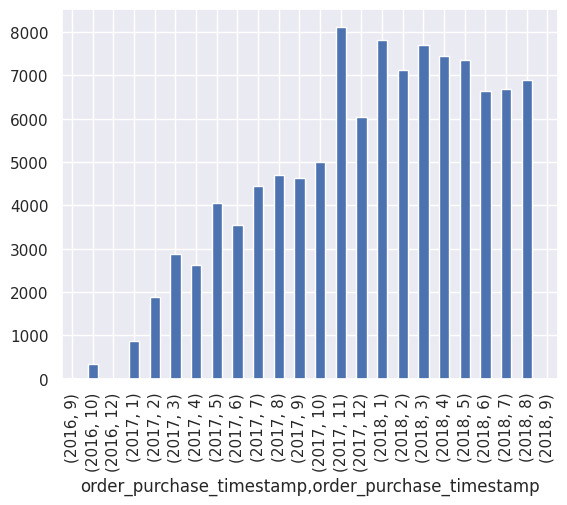

Colonne order_approved_at


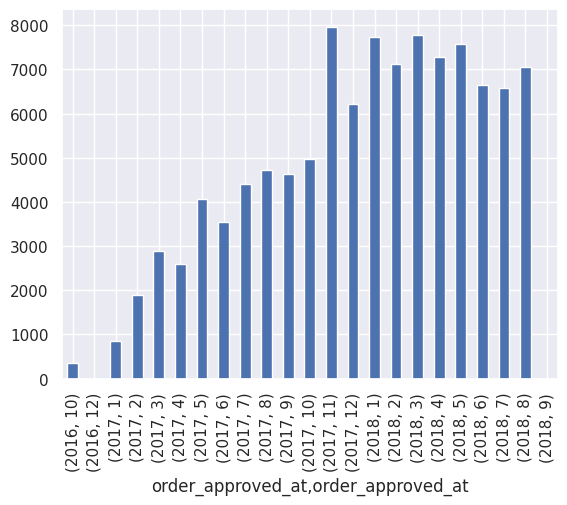

Colonne order_delivered_carrier_date


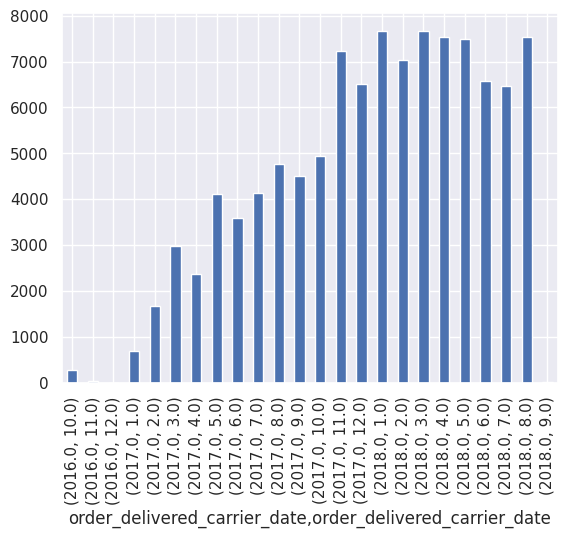

Colonne order_delivered_customer_date


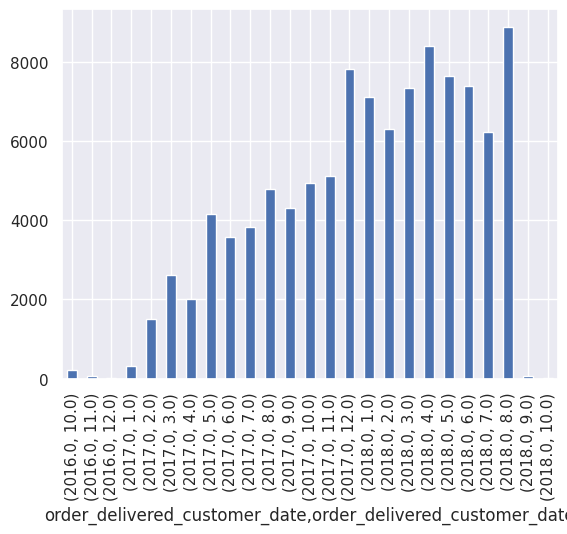

Colonne order_estimated_delivery_date


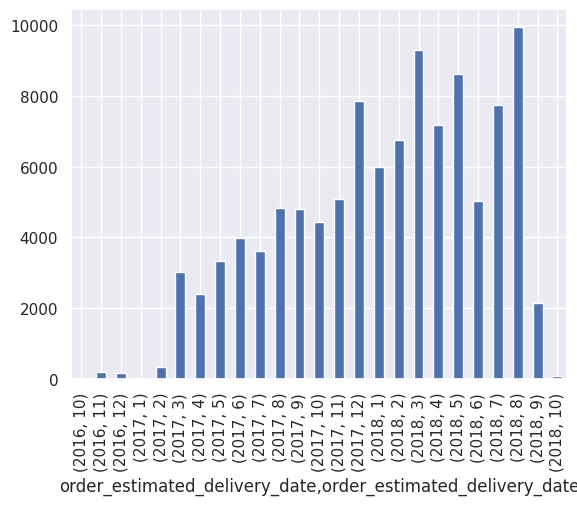

Colonne review_creation_date


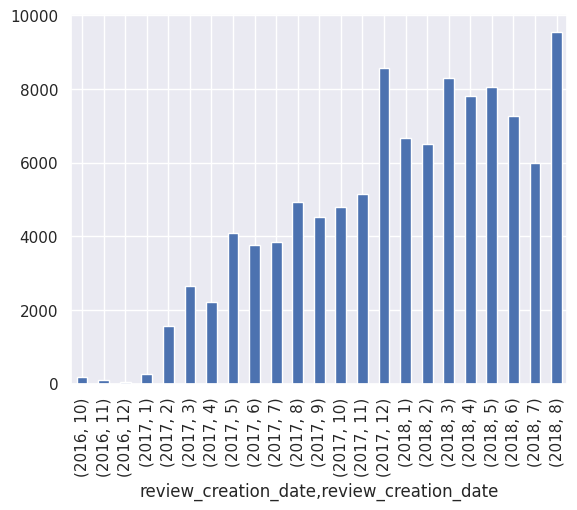

Colonne review_answer_timestamp


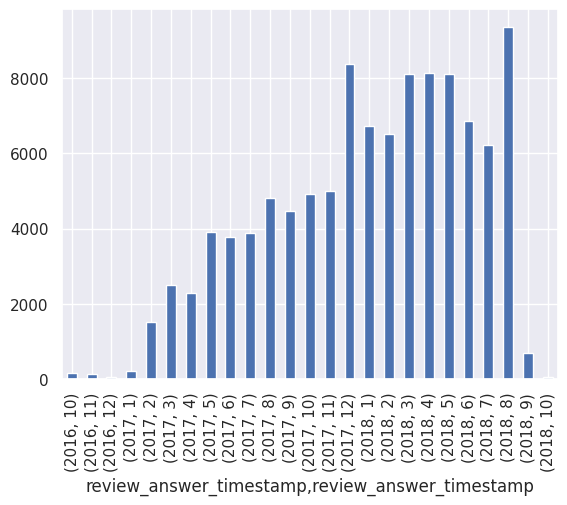

Colonne shipping_limit_date


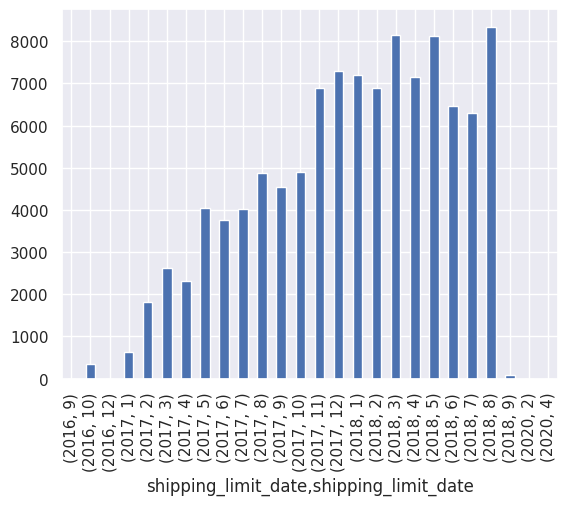

In [85]:
for col in data_date.columns:
    print("Colonne", col)
    data[col].groupby([data[col].dt.year, data[col].dt.month]).count().plot(kind="bar")
    plt.show()

La colonne `order_purchase_timestamp` sera utilisée dans le calcul des variables RFM.  
Nous avons des dates allant de 09/2016 à 04/2020.  
Il est intéressant de comparer les dates de commande, de livraison, de livraison estimée et de création de review.

In [86]:
data['efficient_delivery_elapse'] = (data['order_estimated_delivery_date'] - data['order_delivered_customer_date'])/np.timedelta64(1, 'D')

posx and posy should be finite values
posx and posy should be finite values


----------------------------------------------------------------------
Colonne : efficient_delivery_elapse
moyenne :  11.346722999471432
médiane :  12.065104166666666
mode :  0    15.467847
Name: efficient_delivery_elapse, dtype: float64
min :  -188.97508101851852
max :  146.0161226851852
quartiles :  [nan, nan]
variance :  103.08758036520348
écart-type :  10.153205423175653
coefficient de variation :  0.8948138968095566
skewness :  -2.0173133999570285
kurtosis :  28.791269321780526


posx and posy should be finite values
posx and posy should be finite values


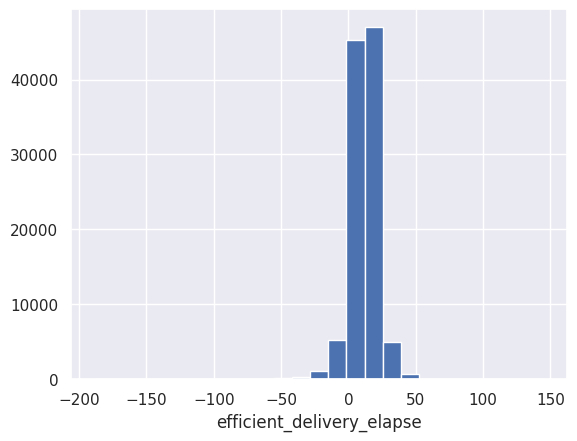

----------------------------------------------------------------------


In [87]:
plot_univarie(data, ["efficient_delivery_elapse"])

D'après ces données, les commandes ont en moyenne 11 jours d'avance pour la livraison comparée à l'estimation.

In [88]:
data["period"] = data['order_purchase_timestamp'].dt.strftime('%Y-%m')

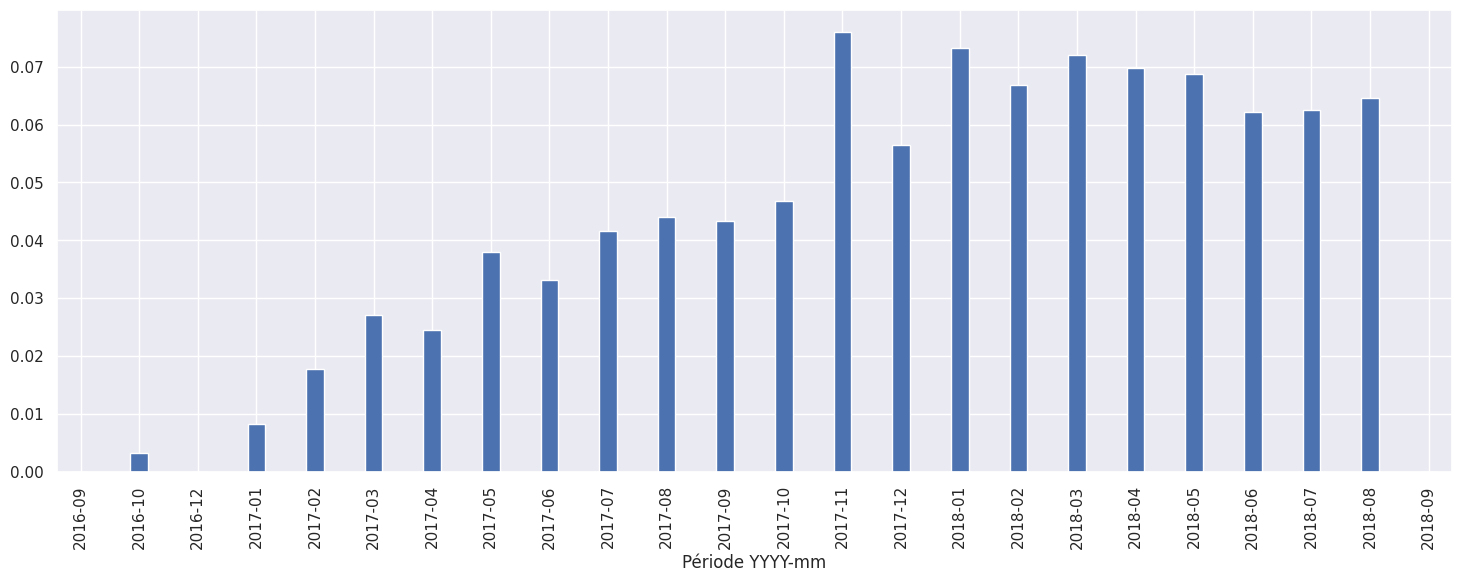

In [89]:
plt.figure(figsize=(18,6))
data['period'].value_counts(normalize=True).sort_index().plot(kind='bar', width=0.3)
plt.xlabel("Période YYYY-mm")
plt.show()

### Colonnes Catégorielles

Colonne : customer_city


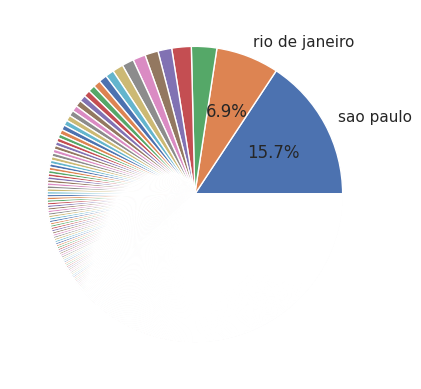

Colonne : customer_state


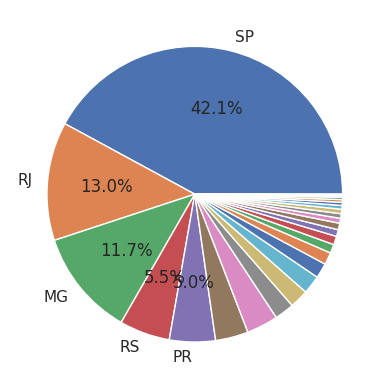

Colonne : order_status


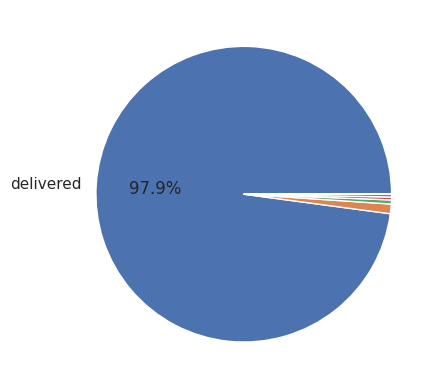

Colonne : payment_type


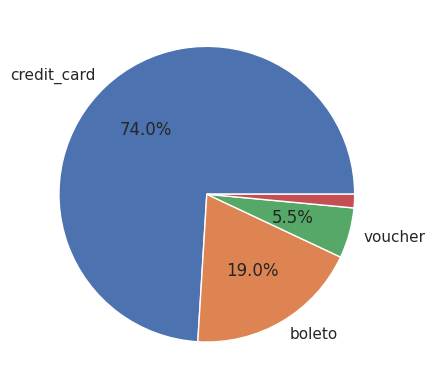

Colonne : product_category_name


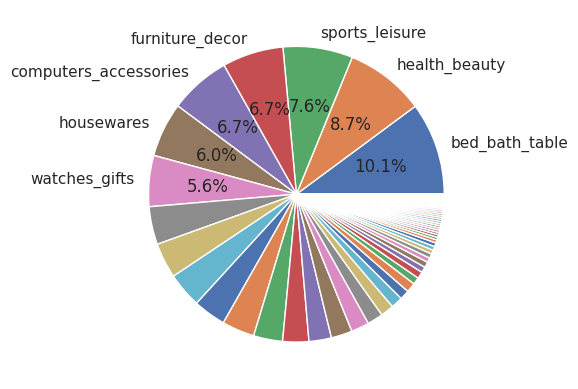

Colonne : seller_city


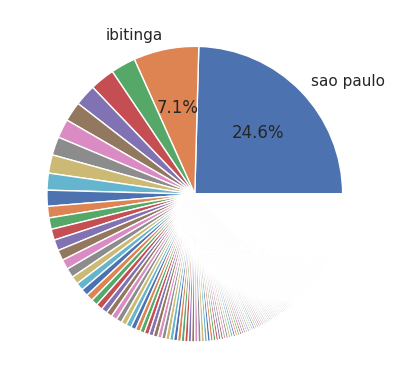

Colonne : seller_state


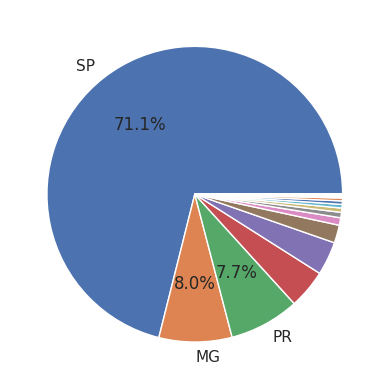

In [90]:
categ_col = [x for x in data_categ.columns if (not x.endswith("_id") and not x.endswith("_prefix"))]
display_pie_plot(data, categ_col)

### Colonnes Numériques

In [91]:
show_corr_col(data, data_num, threshold=0.3, top=10)

,col1,col2,corr
1,payment_value,price,0.873
6,freight_value,product_weight_g,0.613
11,product_weight_g,product_height_cm,0.580
13,product_length_cm,product_width_cm,0.553
12,product_weight_g,product_width_cm,0.512
10,product_weight_g,product_length_cm,0.467
2,payment_value,freight_value,0.434
4,price,freight_value,0.419
8,freight_value,product_height_cm,0.395
3,payment_value,product_weight_g,0.347


On remarque plusieurs corrélations : 
 - très forte corrélation (>0.8) : entre le prix de l'item et le montant du paiement. Ceci est dû au fait que beaucoup de paiement ont été fait en 1 fois.
 - forte corrélation (>0.6) : entre le poids du produit et les frais de port. Ce qui semble logique.
 - corrélation modérée (>0.4) : entre les différentes dimensions et le poids. Ce qui semble logique également. Mais aussi entre les frais de port et le prix. C'est moins logique, mais pour ça que la corrélation est modérée.

Les corrélations ne sont pas assez fortes pour écarter une variable ou une autre.

In [92]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_sequential,106837.0,1.094761,0.723067,1.000000,1.0000,1.000000,1.00000,29.000000
payment_installments,106837.0,2.896029,2.724191,1.000000,1.0000,1.000000,4.00000,24.000000
payment_value,106837.0,156.943631,217.198052,0.010000,57.6800,102.120000,175.94000,13664.080000
review_score,106837.0,4.073589,1.355780,1.000000,4.0000,5.000000,5.00000,5.000000
order_item_id,106837.0,1.149723,0.557548,1.000000,1.0000,1.000000,1.00000,21.000000
price,106837.0,124.163629,188.103947,0.850000,40.0000,78.000000,139.00000,6735.000000
freight_value,106837.0,20.144767,15.914993,0.000000,13.1400,16.340000,21.23000,409.680000
product_name_lenght,106837.0,48.235583,11.230665,5.000000,42.0000,52.000000,57.00000,76.000000
product_description_lenght,106837.0,773.963206,653.043843,4.000000,340.0000,594.000000,977.00000,3992.000000
product_photos_qty,106837.0,2.217986,1.734293,1.000000,1.0000,1.000000,3.00000,20.000000


----------------------------------------------------------------------
Colonne : payment_sequential
moyenne :  1.0947611782434925
médiane :  1.0
mode :  0    1
Name: payment_sequential, dtype: int64
min :  1
max :  29
quartiles :  [1.0, 1.0]
variance :  0.5228210997263391
écart-type :  0.7230636899515416
coefficient de variation :  0.6604761881597527
skewness :  15.946531104441336
kurtosis :  354.7274555402103


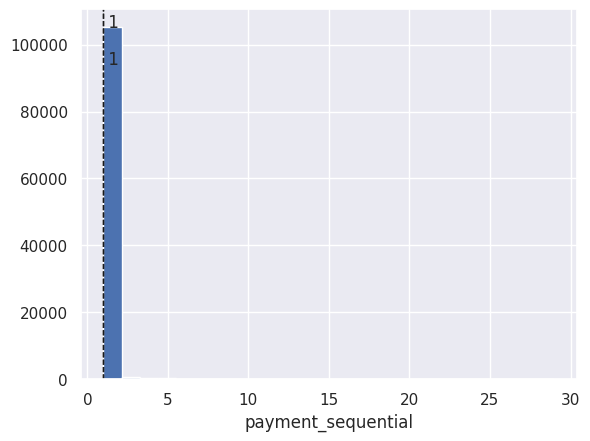

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_installments
moyenne :  2.8960285294420474
médiane :  1.0
mode :  0    1
Name: payment_installments, dtype: int64
min :  1
max :  24
quartiles :  [1.0, 4.0]
variance :  7.421147026826309
écart-type :  2.7241782296366566
coefficient de variation :  0.9406600114403916
skewness :  1.631248533849498
kurtosis :  2.484047074073441


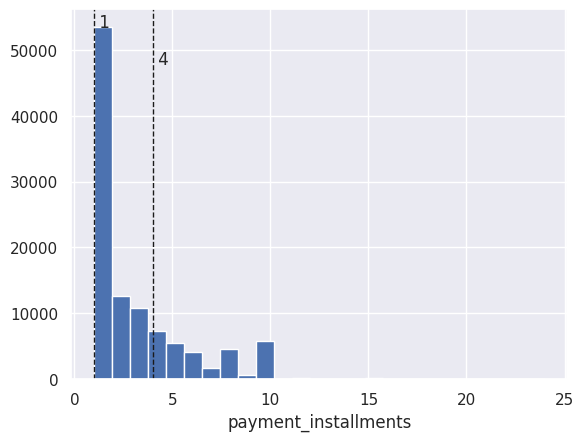

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_value
moyenne :  156.9436312326254
médiane :  102.12
mode :  0    50.0
Name: payment_value, dtype: float64
min :  0.01
max :  13664.08
quartiles :  [57.68, 175.94]
variance :  47174.552082731294
écart-type :  217.19703516100603
coefficient de variation :  1.383917483335604
skewness :  8.89096971725567
kurtosis :  229.03704633959828


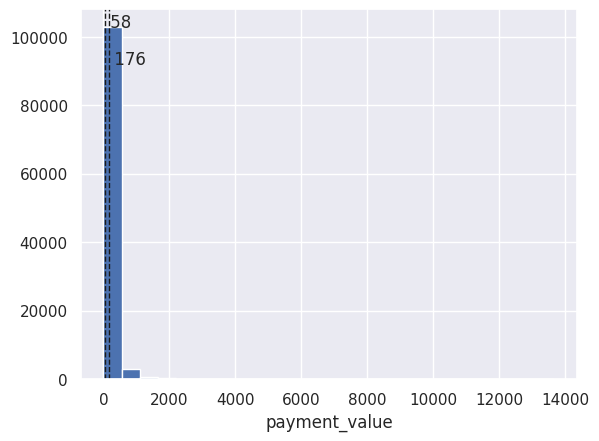

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : review_score
moyenne :  4.073588737984032
médiane :  5.0
mode :  0    5
Name: review_score, dtype: int64
min :  1
max :  5
quartiles :  [4.0, 5.0]
variance :  1.8381220489340726
écart-type :  1.355773597963197
coefficient de variation :  0.33282044044391
skewness :  -1.339721309644671
kurtosis :  0.4286654687268805


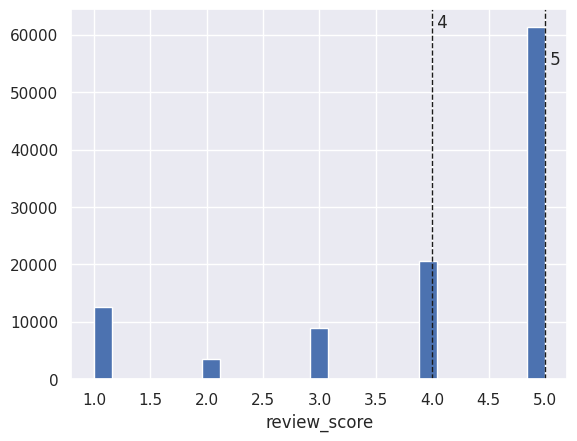

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.1497234104289713
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  21
quartiles :  [1.0, 1.0]
variance :  0.31085695336613883
écart-type :  0.5575454720165333
coefficient de variation :  0.48493878350142355
skewness :  7.250331583154542
kurtosis :  102.58532605090602


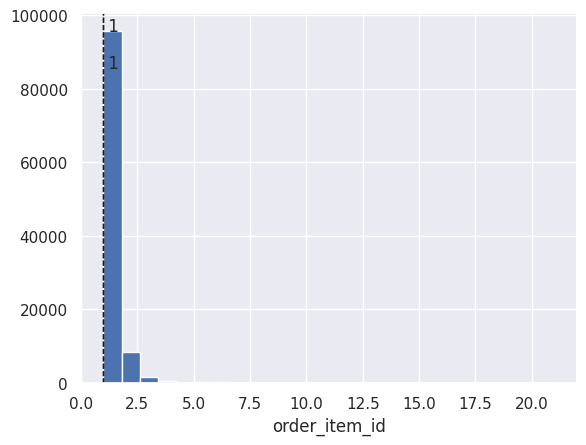

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : price
moyenne :  124.16362861181051
médiane :  78.0
mode :  0    59.9
Name: price, dtype: float64
min :  0.85
max :  6735.0
quartiles :  [40.0, 139.0]
variance :  35382.76382003048
écart-type :  188.10306701388598
coefficient de variation :  1.5149610970373455
skewness :  7.547338449468095
kurtosis :  104.87654903721153


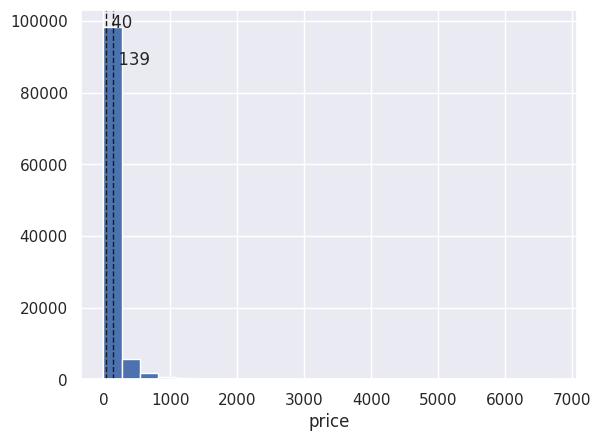

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value
moyenne :  20.144767449479108
médiane :  16.34
mode :  0    15.1
Name: freight_value, dtype: float64
min :  0.0
max :  409.68
quartiles :  [13.14, 21.23]
variance :  253.28461584233258
écart-type :  15.914918028137393
coefficient de variation :  0.790027388901375
skewness :  5.457539302979008
kurtosis :  55.61923631587105


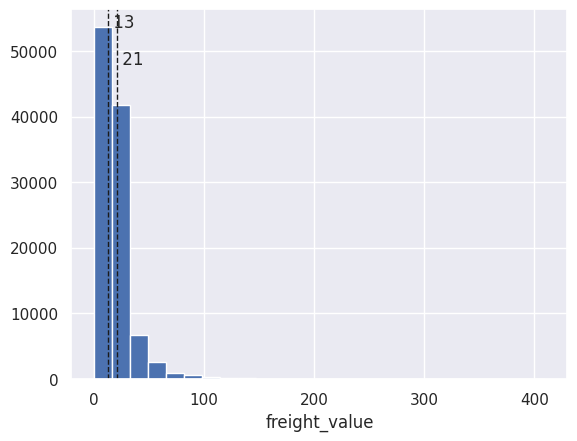

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_name_lenght
moyenne :  48.23558317811245
médiane :  52.0
mode :  0    59.0
Name: product_name_lenght, dtype: float64
min :  5.0
max :  76.0
quartiles :  [42.0, 57.0]
variance :  126.1266565608365
écart-type :  11.230612474875825
coefficient de variation :  0.2328283755460402
skewness :  -1.3332628730500486
kurtosis :  2.026693743866997


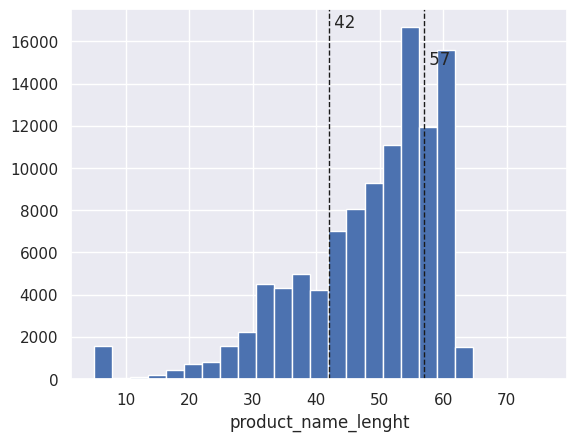

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght
moyenne :  773.963205631008
médiane :  594.0
mode :  0    4.0
Name: product_description_lenght, dtype: float64
min :  4.0
max :  3992.0
quartiles :  [340.0, 977.0]
variance :  426462.2694980329
écart-type :  653.040787009535
coefficient de variation :  0.8437620577545601
skewness :  1.9930095047986836
kurtosis :  4.916238463472136


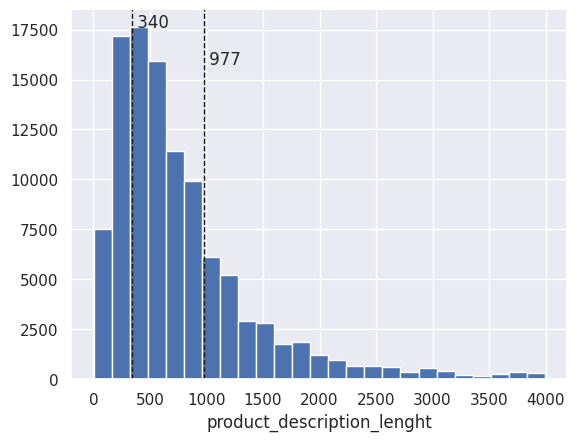

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty
moyenne :  2.21798627816206
médiane :  1.0
mode :  0    1.0
Name: product_photos_qty, dtype: float64
min :  1.0
max :  20.0
quartiles :  [1.0, 3.0]
variance :  3.007743736419815
écart-type :  1.7342847910362977
coefficient de variation :  0.781918629574849
skewness :  1.8964902827227141
kurtosis :  4.731144502455345


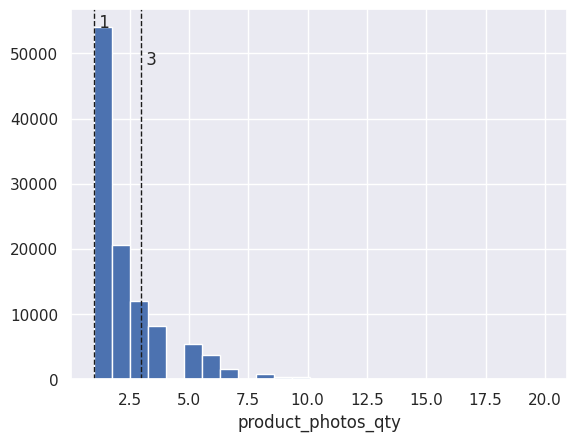

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_weight_g
moyenne :  2106.84086973614
médiane :  700.0
mode :  0    200.0
Name: product_weight_g, dtype: float64
min :  2.0
max :  40425.0
quartiles :  [300.0, 1800.0]
variance :  14321137.465406427
écart-type :  3784.3278749873707
coefficient de variation :  1.7962096375419745
skewness :  3.6087655943420685
kurtosis :  16.27537624604445


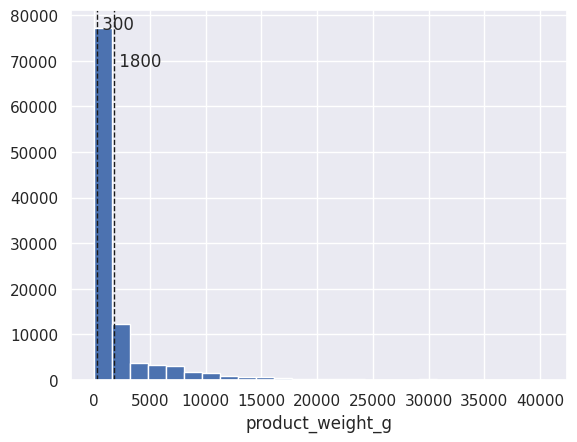

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_length_cm
moyenne :  30.18379400394994
médiane :  25.0
mode :  0    16.0
Name: product_length_cm, dtype: float64
min :  7.0
max :  105.0
quartiles :  [18.0, 38.0]
variance :  260.20769041566535
écart-type :  16.130954417382295
coefficient de variation :  0.5344243475578766
skewness :  1.7549161192822962
kurtosis :  3.7308755657282173


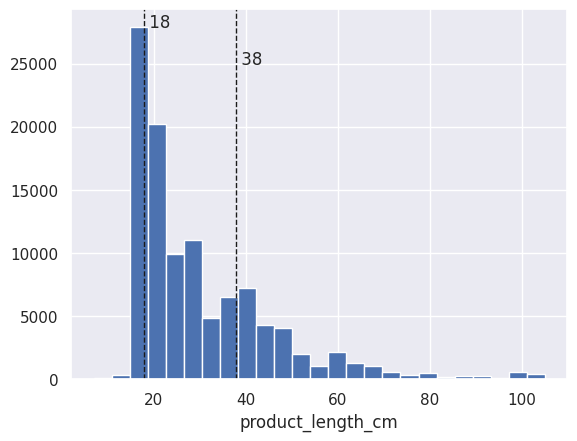

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_height_cm
moyenne :  16.425489296779205
médiane :  13.0
mode :  0    10.0
Name: product_height_cm, dtype: float64
min :  2.0
max :  105.0
quartiles :  [8.0, 20.0]
variance :  177.42420797614136
écart-type :  13.320067866799379
coefficient de variation :  0.8109388783572643
skewness :  2.2628873277754225
kurtosis :  7.502769645787423


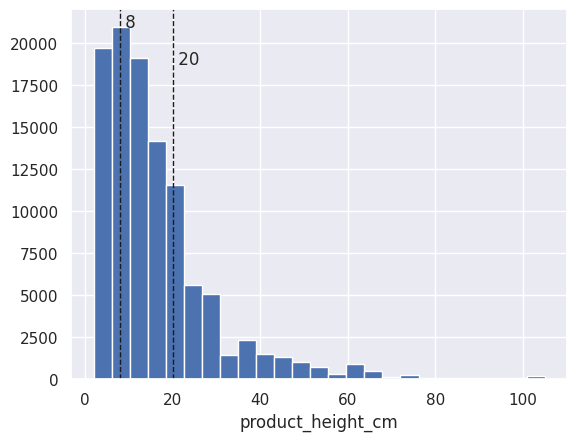

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_width_cm
moyenne :  23.106742046294823
médiane :  20.0
mode :  0    20.0
Name: product_width_cm, dtype: float64
min :  6.0
max :  118.0
quartiles :  [15.0, 30.0]
variance :  138.78701867053599
écart-type :  11.780790239645896
coefficient de variation :  0.5098421151732618
skewness :  1.692967234885271
kurtosis :  4.429648710147635


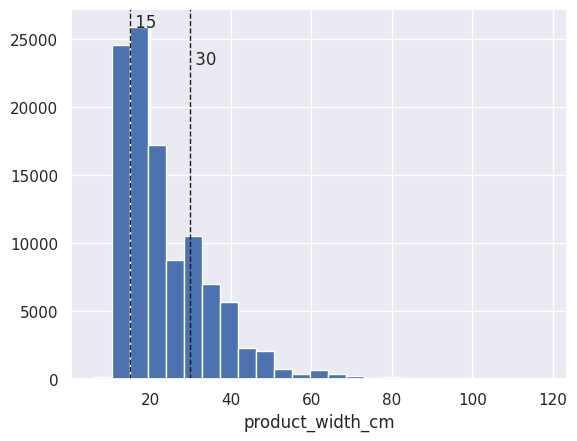

----------------------------------------------------------------------


In [93]:
plot_univarie(data, data_num.columns)

### Colonnes Numériques et Catégorielles

In [94]:
# show_corr_anova_col(data, categ_col, data_num.columns, threshold=0.3)

La recherche de corrélation entre les variables catégorielles et les variables nuémriques n'a rien donné pour un seuil supérieure à 0.3.

### Colonnes Dates et Numériques

In [95]:
data = data.sort_values(by="period")

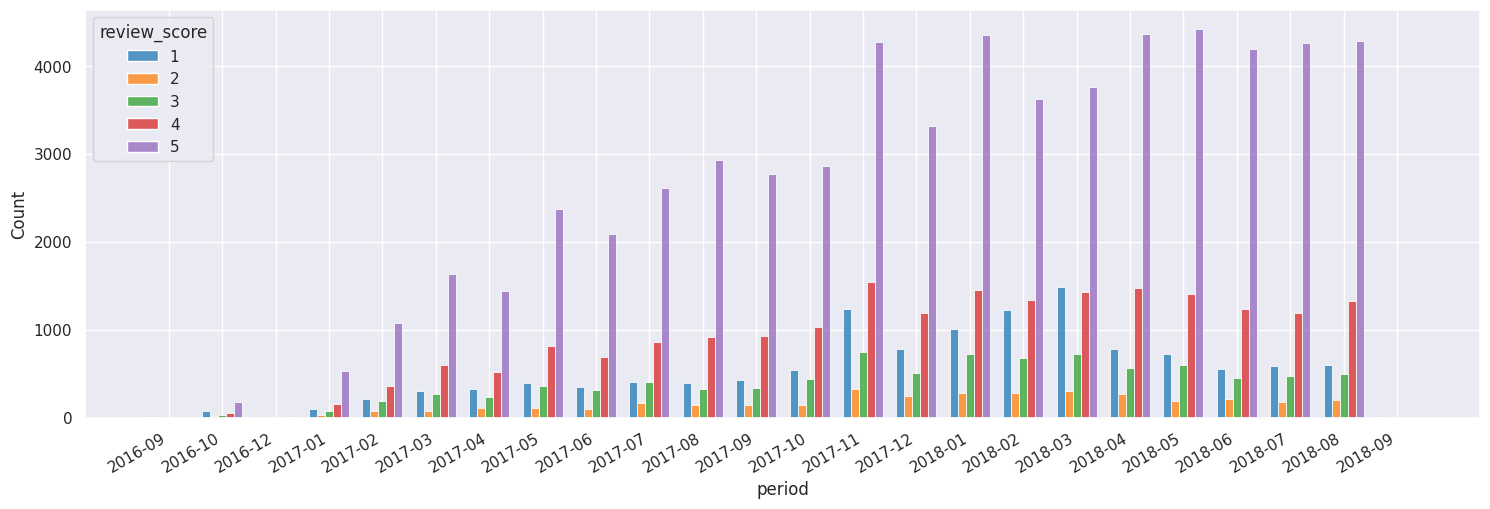

In [96]:
import matplotlib.dates as mdates
plt.figure(figsize=(18,6))
sns.histplot(data, x='period', hue='review_score',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()